# Kaggle: Titanic Challenge
## Coded by Daniel Wilcox

This is a notebook showing the process in predicting the survivors of the Titanic.

In [23]:
import os
import pickle


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#Fills in values to empty data locations
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Creating custom Transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer



from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix


from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier


In [2]:
#The Location to save the dataset
TITANIC_PATH = "datasets/titanic"
TITANIC_URL = "https://github.com/Daniel-Wilcox/ADA-874-2019/blob/master/datasets/titanic/"
train_name = "train.csv" 
test_name = "test.csv" 


#The Location to save the models
PICKLE_PATH = "PickleModels/Titanic"

In [3]:
#Pickle functions

#Saving and storing the model
def save_pickle(model_name, model, pic_path=PICKLE_PATH):
    print("Saving model...")
    
    cwd = os.getcwd()
    os.chdir(cwd+"/"+pic_path)
        
    f = open(model_name, "wb")
    pickle.dump(model, f)
    f.close()
    
    os.chdir(cwd)
    print("Saved "+model_name+" successfully!\n")
    return None
    
    
#Retrieving and loading the model
def load_pickle(model_name, pic_path=PICKLE_PATH):
    print("Loading "+model_name+" from Pickle file...")
    
    cwd = os.getcwd()
    os.chdir(cwd+"/"+pic_path)
    
    f = open(model_name, "rb")
    p = pickle.load(f)
    f.close()
    
    os.chdir(cwd)
    print(model_name+" successfully loaded!\n")
    return p

#Check whether the pickel exists
def pickle_exist(model_name, pic_path=PICKLE_PATH):
    #check if pickle file exists
    print("Checking if pickle directory exists...")
    if not os.path.isdir(pic_path):
        os.makedirs(pic_path)
        print("Directory does NOT exists")
        print("Creating directory")
    
    else: 
        print("Directory exists")
        
    if os.path.isfile(pic_path+"/"+model_name):
        print("Pickle file does exists...")
        return True
    else:
        print("Pickle file does NOT exists...")
        return False

In [4]:
def load_Titanic_data(file_name, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, file_name)
    return pd.read_csv(csv_path)
        
    
def get_Titanic_data(file_name, titanic_url=TITANIC_URL, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, file_name)
    
    print("Checking if directory exists...")
    if not os.path.isdir(titanic_path):
        os.makedirs(titanic_path)
        print("Creating directory")
    
    else: 
        print("Directory exists") 
            
        if os.path.isfile(csv_path):
            print(file_name + " file does exists...")
            print("extracting " + file_name)
            
            titanic = load_Titanic_data(file_name)
            print("\nSuccess!")
            return titanic
        
        else:
            print(file_name + " file doesn't exists...")
            print("Download .csv from Kaggle!")

            return None
        
    
    
            

In [5]:
Train = get_Titanic_data(train_name)
Test = get_Titanic_data(test_name)


Checking if directory exists...
Directory exists
train.csv file does exists...
extracting train.csv

Success!
Checking if directory exists...
Directory exists
test.csv file does exists...
extracting test.csv

Success!


In [6]:
Train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB



### Variable - Definition                              - Key
1. survival - Survival                                - 0/1 = No/Yes
2. pclass   - Ticket class                            - 1,2,3 = 1st, 2nd, 3rd class
3. sex      - Sex                                     - male, female
4. Age      - Age in years                            - ...
5. sibsp    - # of siblings/spouses on the Titanic    - ...
6. parch    - # of parents/children on the Titanic    - ...
7. ticket   - Ticket number                           - ...
8. fare     - Passenger fare                          - ...
9. cabin    - Cabin number                            - ...
10. embarked - Port of Embarkation                     - C = Cherbourg, Q = Queenstown, S = Southampton


In [7]:
Train.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [8]:
sur = Train["Survived"].value_counts() / len(Train)
print("{:.2f}% Survived\n{:.2f}% Died".format(100*sur[1],100*sur[0]))

38.38% Survived
61.62% Died


In [9]:
#Correlation matrix
corr_matrix = Train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [10]:
#Split "Train" into Training and Verification datasets

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)

for train_index, ver_index in split.split(Train, Train["Survived"]):
    Train_strat = Train.loc[train_index]
    Ver_strat = Train.loc[ver_index]

print("Training set: {} entries, Verificaiton set: {} entries".format(len(Train_strat),len(Ver_strat)))


Training set: 712 entries, Verificaiton set: 179 entries


In [11]:
#Separtate labels from features
y_train = Train_strat["Survived"].copy()
X_train = Train_strat.drop("Survived", axis=1)

y_ver = Ver_strat["Survived"].copy()
X_ver = Ver_strat.drop("Survived", axis=1)


In [12]:
#Remove Features (survived is already removed)
list_drop = ['Name', 'Ticket', 'Cabin']

Dropped = X_train[list(set(X_train.columns) - set(list_drop))]

#Numeric Features
list_num = Dropped.select_dtypes(include = ["number"]).columns

#Catagorical Features (to be transformed into OHE)
list_cat = Dropped.select_dtypes(include = ["object"]).columns


In [13]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return(self)
    
    def transform(self, X):
        return X[self.feature_names].values    

In [14]:
#Numeric Transformations
num_pipeline = Pipeline([
    ('selector', Selector(list_num)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

#Catagorical Transformations
cat_pipeline = Pipeline([
    ('selector', Selector(list_cat)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [15]:
perpare_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

X_tr = perpare_pipeline.fit_transform(X_train)
X_tr.shape

(712, 11)

In [16]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_tr, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
X_v = perpare_pipeline.fit_transform(X_ver)
y_predict = sgd_clf.predict(X_v)

acc = accuracy_score(y_ver, y_predict)
print("Accuracy Score: {:.2f}%\n".format(acc*100))

Accuracy Score: 73.74%



In [19]:
con_m = confusion_matrix(y_ver, y_predict)

print("True Neg:  {}\t\tFalse Pos: {}\nFalse Neg: {}\t\tTrue Pos:  {}\n"
      .format(con_m[0][0], con_m[0][1], con_m[1][0], con_m[1][1]))

True Neg:  93		False Pos: 17
False Neg: 30		True Pos:  39



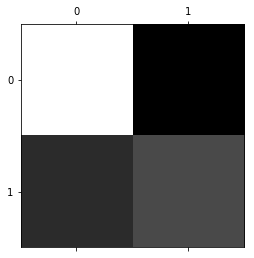

In [22]:
plt.matshow(con_m, cmap=plt.cm.gray)
plt.show()

In [ ]:
#classifiers

#from sklearn.svm import LinearSVC
#from sklearn.svm import SVC
#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import SGDClassifier
#from sklearn.neighbors import KNeighborsClassifier




In [ ]:
#To create new model if pickle already even if pickle exists; load_pkl = False
load_pkl = True

    
#Linear Support Vector Classifier
if pickle_exist("lin_clf") and load_pkl:
    lin_clf = load_pickle("lin_clf")
else:
    lin_clf = LinearSVC(loss="hinge", C=C, 
                        random_state=42)
    lin_clf.fit(X_scaled, y_new)
    save_pickle("lin_clf", lin_clf)
    
    
    

#Support Vector Machine Classifier    
if pickle_exist("svc_clf") and load_pickle:
    svc_clf = load_pickle("svc_clf")
else:
    svc_clf = SVC(kernel="linear",  C=C)
    svc_clf.fit(X_scaled, y_new)
    save_pickle("svc_clf", svc_clf)
    
    

#Stochastic Gradient Descent Classifier    
if pickle_exist("sgd_clf") and load_pickle:
    sgd_clf = load_pickle("sgd_clf")
else:
    sgd_clf = SGDClassifier(
        loss="hinge", alpha=1/(m*C), random_state=42)
    sgd_clf.fit(X_scaled, y_new)
    save_pickle("sgd_clf", sgd_clf)